In [64]:
import numpy as np
from skimage import io, color
import matplotlib.pyplot as plt
from skimage import exposure
%matplotlib inline

In [72]:
def convolve(image, kernel):
    
    output = np.zeros_like(image)
    #kernel = np.flipud(np.fliplr(kernel))
    padded_img = np.zeros((image.shape[0] + 2, image.shape[1] + 2))
    padded_img[1:-1, 1:-1] = image
    
    for x in range(image.shape[1]):
        for y in range(image.shape[0]):
            output[y,x]=(kernel*padded_img[y:y+3,x:x+3]).sum()
       
    return output

In [101]:
def reduce(image):
    hkernel = np.array([1,2,1]) # gaussian blur
    vkernel = np.array([[1],[2],[1]])
    output = np.zeros((int(image.shape[0]/2), int(image.shape[1]/2)))
    img = np.zeros_like(image)
    img = convolve(image, hkernel)
    img = convolve(img, vkernel)
        
    for x in range(image.shape[1]):
        for y in range(image.shape[0]):
            output[int(y/2),int(x/2)] = img[y, x]    
    
    return output
    

In [138]:
def expand(image):    
    output = np.repeat(image, 2, axis=1)
    output = np.repeat(output, 2, axis=0)

    return output

In [160]:
def gaussianPyramid(image, n):
    images = []
    images.append(image)
    for i in range(n-1):
        image = reduce(image)
        images.append(image)
    return images

In [157]:
def laplacianPyramid(image, n):
    images = gaussianPyramid(image, n)
    laplacian = []
    for i in range(n):
        laplacian.append(images[i + 1] - images[i])
    return laplacian

In [67]:
img = io.imread('Unknown')
img = color.rgb2gray(img)

/Users/Vineeth/anaconda/lib/python3.6/site-packages/skimage/util/dtype.py:122: UserWarning: Possible precision loss when converting from float64 to uint16
  .format(dtypeobj_in, dtypeobj_out))


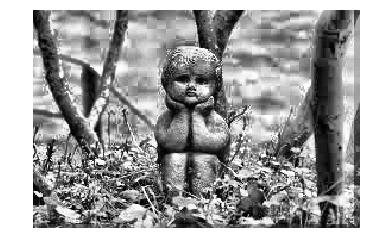

In [68]:
image_equalized = exposure.equalize_adapthist(img/np.max(np.abs(img)), clip_limit=0.03)
plt.imshow(image_equalized, cmap=plt.cm.gray)
plt.axis('off')
plt.show()

In [163]:
kernel = np.array([[0,-1,0],[-1,5,-1],[0,-1,0]])
kernel = np.array([[1,2,1],[2,4,2],[1,2,1]]) # gaussian blur
sharper_img = convolve(img, kernel)

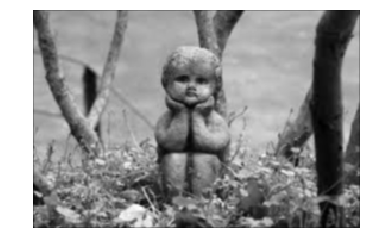

In [164]:
plt.imshow(sharper_img, cmap=plt.cm.gray)
plt.axis('off')
plt.show()

In [165]:
reduced_img = reduce(img)

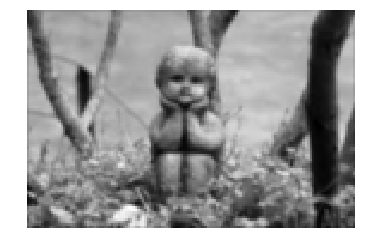

In [166]:
plt.imshow(reduced_img, cmap=plt.cm.gray)
plt.axis('off')
plt.show()

In [97]:
reduced_img.shape

(91, 137)

In [98]:
img.shape

(183, 275)

In [167]:
expanded_img = expand(img)

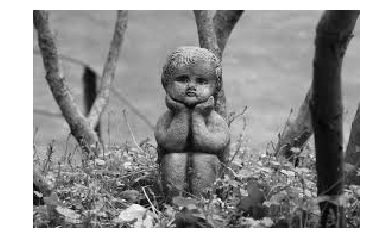

In [168]:
plt.imshow(expanded_img, cmap=plt.cm.gray)
plt.axis('off')
plt.show()

In [153]:
img.shape

(183, 275)

In [154]:
expanded_img.shape

(366, 550)

In [161]:
images = gaussianPyramid(img, 3)

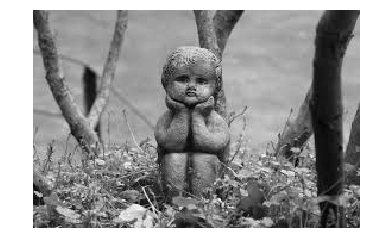

(183, 275)


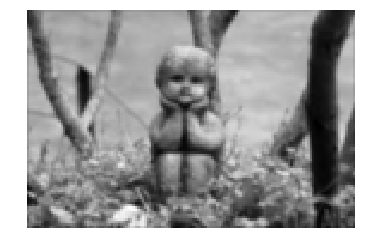

(91, 137)


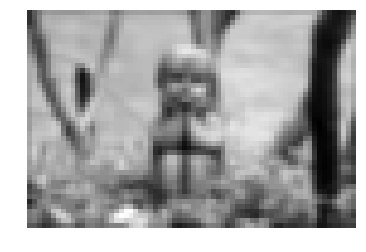

(45, 68)


In [162]:
for i in images:
    plt.imshow(i, cmap=plt.cm.gray)
    plt.axis('off')
    plt.show()
    print(i.shape)

In [159]:
laplacianPyramid(img, 2)

ValueError: operands could not be broadcast together with shapes (45,68) (91,137) 

In [52]:
np.array([1,2,1])

array([1, 2, 1])

In [53]:
np.array([[1],[2],[1]])

array([[1],
       [2],
       [1]])

In [54]:
hkernel = np.array([1,2,1]) # gaussian blur
vkernel = np.array([[1],[2],[1]])
hkernel * vkernel

array([[1, 2, 1],
       [2, 4, 2],
       [1, 2, 1]])

In [118]:
test = np.array([[1,2,3],[4,5,6],[7,8,9]])
output = np.zeros((test.shape[1] * 2, test.shape[0] * 2))
test

array([[1, 2, 3],
       [4, 5, 6],
       [7, 8, 9]])

In [137]:
x = np.repeat(test, 2, axis=1)
np.repeat(x, 2, axis=0)

array([[1, 1, 2, 2, 3, 3],
       [1, 1, 2, 2, 3, 3],
       [4, 4, 5, 5, 6, 6],
       [4, 4, 5, 5, 6, 6],
       [7, 7, 8, 8, 9, 9],
       [7, 7, 8, 8, 9, 9]])